In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plots_folder = 'plots/multi_objective_mcmc'

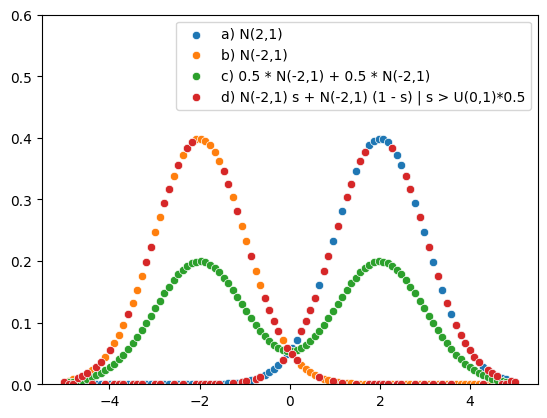

In [2]:
prior = lambda x: np.where((-5 < x) & (x < 5), 1, 0)

def two_gaussian(x, switch=None):
    return stats.norm.pdf(x, -2, 1) * switch + stats.norm.pdf(x, 2, 1) * (1 - switch)

stochastic_two_gaussian = lambda x: two_gaussian(x, switch=np.random.rand(len(x)) < 0.5)
gaussian_a = lambda x: two_gaussian(x, switch=0)
gaussian_b = lambda x: two_gaussian(x, switch=1)
mixed_two_gaussian = lambda x: two_gaussian(x, switch=0.5)

x = np.linspace(-5, 5, 100)
sns.scatterplot(x=x, y=gaussian_a(x))
x = np.linspace(-5, 5, 100)
sns.scatterplot(x=x, y=gaussian_b(x))
x = np.linspace(-5, 5, 100)
sns.scatterplot(x=x, y=mixed_two_gaussian(x))
x = np.linspace(-5, 5, 100)
sns.scatterplot(x=x, y=stochastic_two_gaussian(x))
plt.legend(['a) N(2,1)', 'b) N(-2,1)', 'c) 0.5 * N(-2,1) + 0.5 * N(-2,1)', 'd) N(-2,1) s + N(-2,1) (1 - s) | s > U(0,1)*0.5'])
plt.ylim(0,0.6)

plt.savefig(f'{plots_folder}/likelihood_functions.png')

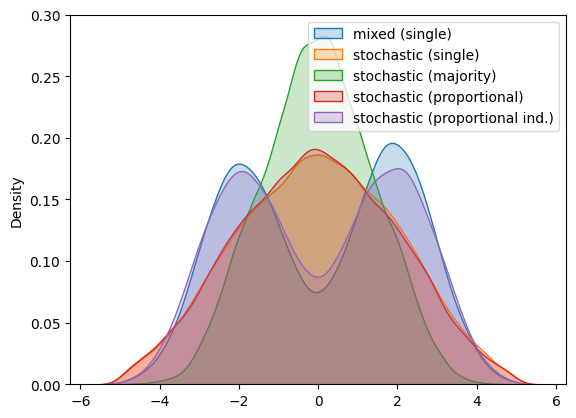

In [11]:
# metropolis hastings with multiple functions
transition = lambda x: np.random.normal(x, 1, (1,))
samples = 100000

def metropolis_hastings(likelihood, prior, transition, param_init, iterations, n_votes=1, rule='majority'):
    x = np.array(param_init)[np.newaxis]
    accepted = []
    rejected = []
    for i in range(iterations):
        x_new = transition(x)
        x_new_expanded = np.repeat(x_new, n_votes, axis=0)
        x_expanded = np.repeat(x, n_votes, axis=0)
        p_new = likelihood(x_new_expanded) * prior(x_new_expanded)
        p = likelihood(x_expanded) * prior(x_expanded)
        if rule == 'majority':       
            alpha = p_new / p
            votes = np.random.rand(n_votes) < alpha
            is_accepted = np.sum(votes) > n_votes / 2
        elif rule == 'proportional':
            alpha = p_new / p
            votes = np.random.rand(n_votes) < alpha
            is_accepted = np.random.rand() < np.mean(votes)
        elif rule == 'proportional_ind':
            alpha = np.sum(p_new) / np.sum(p)
            is_accepted = np.random.rand() < alpha
        else:
            raise ValueError('rule must be either majority or proportional')
        if is_accepted:
            x = x_new
            accepted.append(x_new[0])
        else:
            rejected.append(x_new[0])
    return np.array(accepted), np.array(rejected)

accepted_mh_mixed_single, _ = metropolis_hastings(mixed_two_gaussian, prior, transition, 0, samples)
accepted_mh_stoch_single, _ = metropolis_hastings(stochastic_two_gaussian, prior, transition, 0, samples)
accepted_mh_stoch_major, _ = metropolis_hastings(
    stochastic_two_gaussian, prior, transition, 0, samples, n_votes=10, rule='majority')
accepted_mh_stoch_proportional, _ = metropolis_hastings(
    stochastic_two_gaussian, prior, transition, 0, samples, n_votes=10, rule='proportional')
accepted_mh_stoch_proportional_ind, _ = metropolis_hastings(
    stochastic_two_gaussian, prior, transition, 0, samples, n_votes=10, rule='proportional_ind')

sns.kdeplot(accepted_mh_mixed_single, fill=True)
sns.kdeplot(accepted_mh_stoch_single, fill=True)
sns.kdeplot(accepted_mh_stoch_major, fill=True)
sns.kdeplot(accepted_mh_stoch_proportional, fill=True)
sns.kdeplot(accepted_mh_stoch_proportional_ind, fill=True)
plt.legend(['mixed (single)', 'stochastic (single)', 'stochastic (majority)', 'stochastic (proportional)', 'stochastic (proportional ind.)'])

plt.ylim(0,0.3)
plt.savefig(f'{plots_folder}/metropolis_hasting.png')

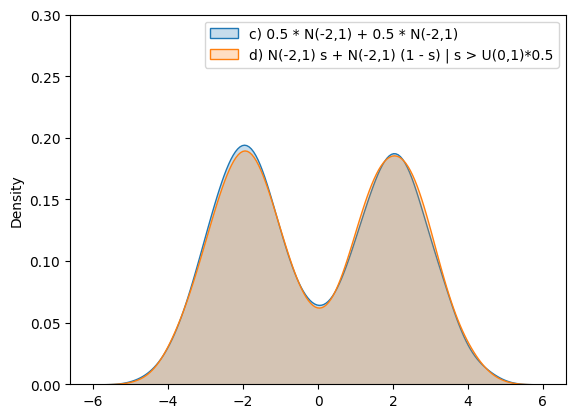

In [4]:
# naive sampling

def naive(likelihood, prior, iterations):
    x = np.random.uniform(-5, 5, iterations)
    accept = np.random.rand(iterations) < likelihood(x) * prior(x)
    return x[accept], x[~accept]

accepted_n_mixed, _ = naive(mixed_two_gaussian, prior, 100000)
accepted_n_stoch, _ = naive(stochastic_two_gaussian, prior, 100000)

sns.kdeplot(accepted_n_mixed, fill=True)
sns.kdeplot(accepted_n_stoch, fill=True)
plt.legend(['c) 0.5 * N(-2,1) + 0.5 * N(-2,1)', 'd) N(-2,1) s + N(-2,1) (1 - s) | s > U(0,1)*0.5'])
plt.ylim(0,0.3)
plt.savefig(f'{plots_folder}/naive_sampling.png')